## ARIMA Model

In [2]:
import investpy as ipy

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [452]:
search_text = "TATA"
try:
    search = ipy.search_quotes(text=search_text, products =["stocks"], countries=["india"], n_results = 1)
except RuntimeError:
    print(RuntimeError)
print("Name: ", search.name)
print("Symbol: ", search.symbol)
print("Exchange: ", search.exchange)

Name:  Tata Communications Limited
Symbol:  TATA
Exchange:  NSE


In [453]:
start_date = "1/1/2000"
end_date = "26/7/2021"
cadence = 'Daily' # Weekly # Do not use unless you've changed logic below (or Monthly)
n_predictions = 100
stock = search.symbol

# -----
step = 1
window = 365
if(cadence == "Weekly"):
    window = 52
elif(cadence == "Monthly"):
    window = 12


### Get Data

In [454]:
# Get the list of dates from start to end date
start = datetime.datetime.strptime(start_date, "%d/%m/%Y")
end = datetime.datetime.strptime(end_date, "%d/%m/%Y")

if(cadence == "Daily"):
    date_array = (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))

    # Update start date
    start_date = start.strftime(format="%d/%m/%Y")

    dates = []
    for i in date_array:
        dates.append(i.strftime("%Y-%m-%d"))

    dates = pd.DataFrame(dates, columns = ["Date"])
    dates["Date"] = pd.to_datetime(dates["Date"])
    dates.head()

In [455]:

# Get Stock Historic Data
df_hist =ipy.stocks.get_stock_historical_data(stock = stock, country = "india", 
                                          from_date = start_date, 
                                          to_date = end_date, 
                                          order = 'ascending', 
                                          interval = cadence # Weekly or Monthly
                                         )
df_hist.reset_index(inplace=True)
df_hist.head(2)

# Getting all the missing dates
if(cadence == "Daily"):
    df = pd.merge(dates, df_hist, on="Date", how="left")
else:
    df = df_hist.copy()
df.sort_values(by="Date", inplace=True, ascending=True)
df.fillna(method="ffill", inplace = True)
df.dropna(inplace=True) # Dropping all null sessions in the beginning

In [456]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Currency
2923,2008-01-02,767.5,769.0,740.0,750.80,395734.0,INR
2924,2008-01-03,740.0,747.0,712.1,717.85,522623.0,INR
2925,2008-01-04,710.0,737.0,710.0,720.45,410558.0,INR
2926,2008-01-05,710.0,737.0,710.0,720.45,410558.0,INR
2927,2008-01-06,710.0,737.0,710.0,720.45,410558.0,INR


In [457]:
df_timeseries = df[["Date", "Open"]].set_index("Date")
df_timeseries.head(5)

,Open
Date,
2008-01-02,767.5
2008-01-03,740.0
2008-01-04,710.0
2008-01-05,710.0
2008-01-06,710.0


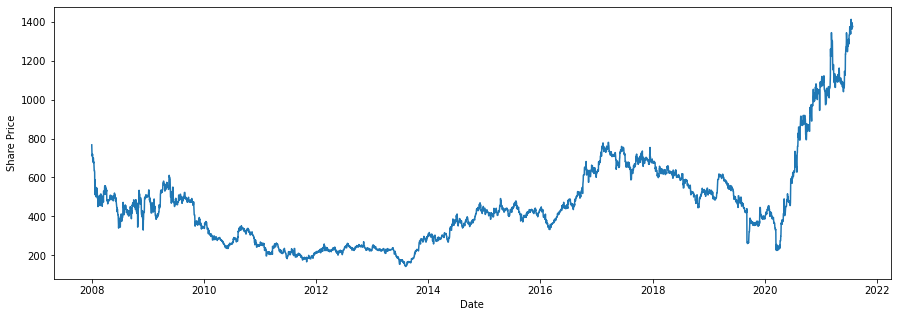

In [458]:
## Plot

plt.xlabel("Date")
plt.ylabel("Share Price")
plt.plot(df_timeseries)

### Functions

In [459]:
# testing stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color = "blue", label="Original Data")
    mean = plt.plot(movingAverage, color="red", label="Rolling Mean")
    std = plt.plot(movingSTD, color = "black", label="Rolling Std")

    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(df_timeseries["Open"], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value",
                                               "#Lags used", "Number of Observations Used"])

    for key, value in dftest[4].items():
        dfoutput["critical Value (%s)"%key] = value
    print(dfoutput)

### Test

In [460]:
# Determing the rolling statistics
rol_mean = df_timeseries.rolling(window=window).mean()
rol_std = df_timeseries.rolling(window=window).std()
print(rol_mean.shape, rol_std.shape)

(4954, 1) (4954, 1)


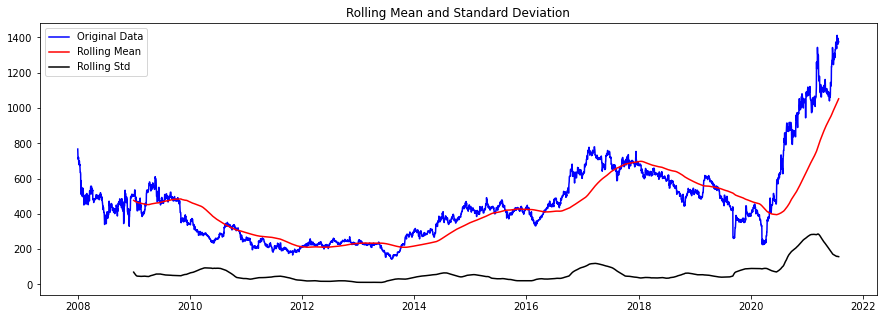

In [461]:
orig = plt.plot(df_timeseries, color = "blue", label="Original Data")
mean = plt.plot(rol_mean, color="red", label="Rolling Mean")
std = plt.plot(rol_std, color = "black", label="Rolling Std")

plt.legend(loc="best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block=False)

In [462]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test:")
dftest = adfuller(df_timeseries["Open"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value",
                                           "#Lags used", "Number of Observations Used"])

for key, value in dftest[4].items():
    dfoutput["critical Value (%s)"%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    0.948345
p-value                           0.993690
#Lags used                       15.000000
Number of Observations Used    4938.000000
critical Value (1%)              -3.431675
critical Value (5%)              -2.862125
critical Value (10%)             -2.567082
dtype: float64


### Transformation

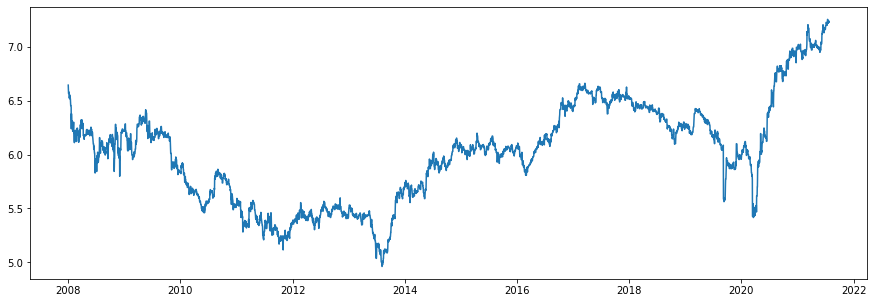

In [463]:
# Log
df_log = np.log(df_timeseries)
plt.plot(df_log)

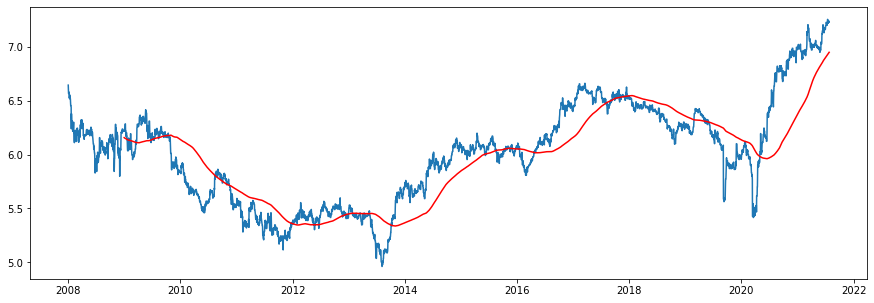

In [464]:
moving_average = df_log.rolling(window=window).mean()
moving_std = df_log.rolling(window = window).std()

plt.plot(df_log)
plt.plot(moving_average, color="red")

In [465]:
# Subtracting moving average from log transformation
df_log_minus_ma = df_log - moving_average

# remove na values (365 starting values)
df_log_minus_ma.dropna(inplace=True)
df_log_minus_ma.head(5)

,Open
Date,
2008-12-31,0.065959
2009-01-01,0.061157
2009-01-02,0.077731
2009-01-03,0.078643
2009-01-04,0.079556


### Checking stationarity post transformation

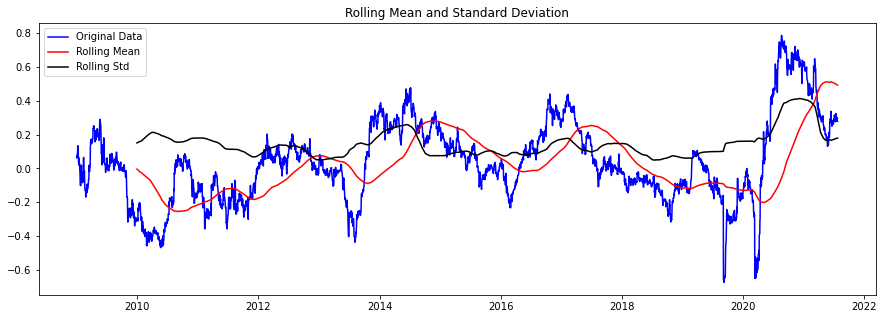

Results of Dickey-Fuller Test:
Test Statistic                    0.948345
p-value                           0.993690
#Lags used                       15.000000
Number of Observations Used    4938.000000
critical Value (1%)              -3.431675
critical Value (5%)              -2.862125
critical Value (10%)             -2.567082
dtype: float64


In [466]:
test_stationarity(df_log_minus_ma)

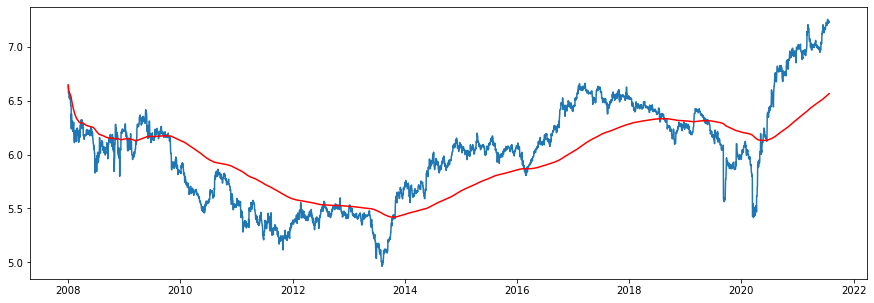

In [467]:
#Exponential Weighted average
expoDecayWeightedAvg = df_log.ewm(halflife=window, min_periods=0, adjust=True).mean()

plt.plot(df_log)
plt.plot(expoDecayWeightedAvg, color="red")
plt.show()

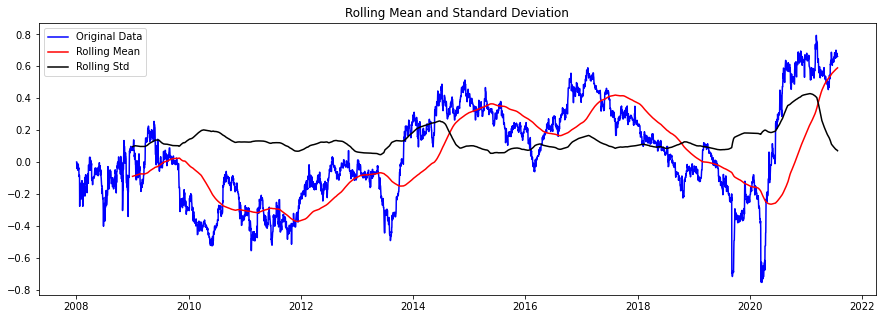

Results of Dickey-Fuller Test:
Test Statistic                    0.948345
p-value                           0.993690
#Lags used                       15.000000
Number of Observations Used    4938.000000
critical Value (1%)              -3.431675
critical Value (5%)              -2.862125
critical Value (10%)             -2.567082
dtype: float64


In [468]:
#Subtracting Exponential Weighted AVG from log transformation
df_log_minus_expoDecay = df_log - expoDecayWeightedAvg
test_stationarity(df_log_minus_expoDecay)

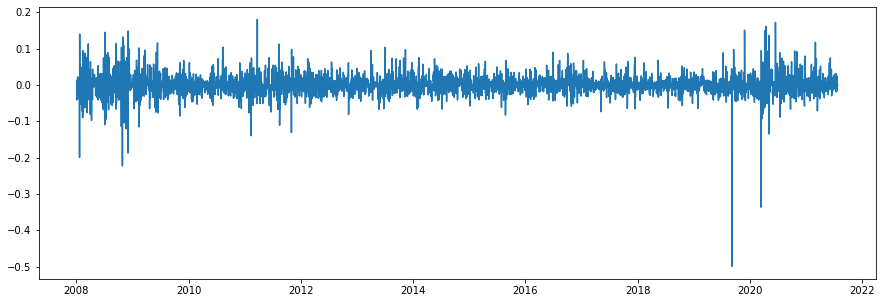

In [469]:
#Subtracting Shifted Data from log transformation
df_log_diff_shifting = df_log - df_log.shift()
plt.plot(df_log_diff_shifting)

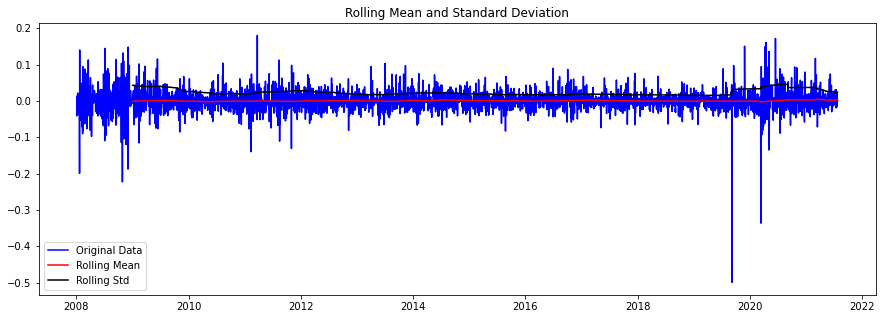

Results of Dickey-Fuller Test:
Test Statistic                    0.948345
p-value                           0.993690
#Lags used                       15.000000
Number of Observations Used    4938.000000
critical Value (1%)              -3.431675
critical Value (5%)              -2.862125
critical Value (10%)             -2.567082
dtype: float64


In [470]:
#Check stationarity of shifted diff of log transformation
df_log_diff_shifting.dropna(inplace=True)
test_stationarity(df_log_diff_shifting)

---

### Checking trend, seasonality and residual elements post decomposition

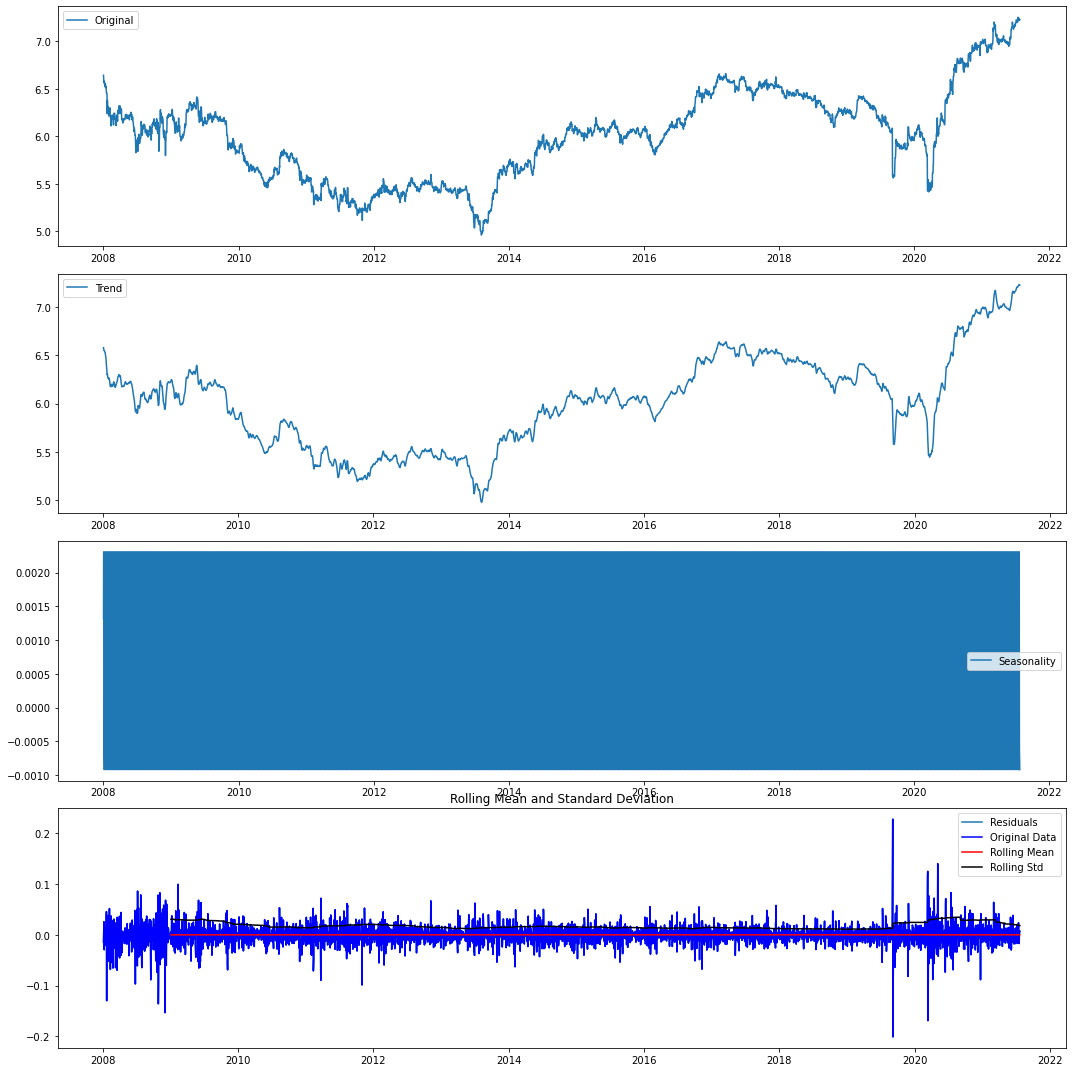

Results of Dickey-Fuller Test:
Test Statistic                    0.948345
p-value                           0.993690
#Lags used                       15.000000
Number of Observations Used    4938.000000
critical Value (1%)              -3.431675
critical Value (5%)              -2.862125
critical Value (10%)             -2.567082
dtype: float64


In [471]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(df_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()


df_decomposed = residual
df_decomposed.dropna(inplace=True)
test_stationarity(df_decomposed)

C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial AutoCorrelation Function')

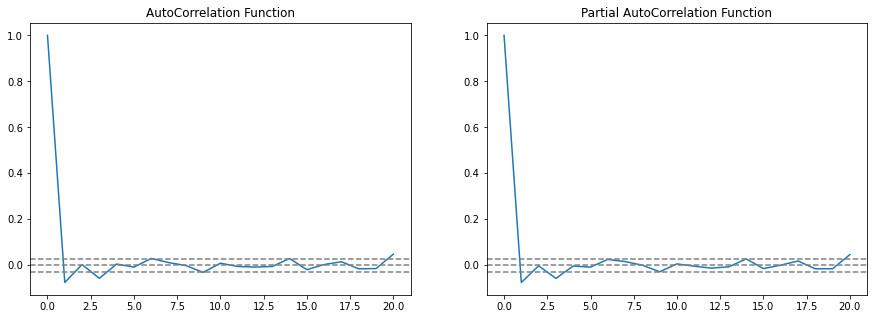

In [472]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf


lag_acf = acf(df_log_diff_shifting, nlags=20)
lag_pacf = pacf(df_log_diff_shifting, nlags=20, method="ols")


#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff_shifting)),
            linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(df_log_diff_shifting)),
            linestyle="--", color="gray")
plt.title("AutoCorrelation Function")


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff_shifting)),
            linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(df_log_diff_shifting)),
            linestyle="--", color="gray")
plt.title("Partial AutoCorrelation Function")

### Arima

In [473]:
AR = 1
MA = 1
I = 1

Plotting AR Model


C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


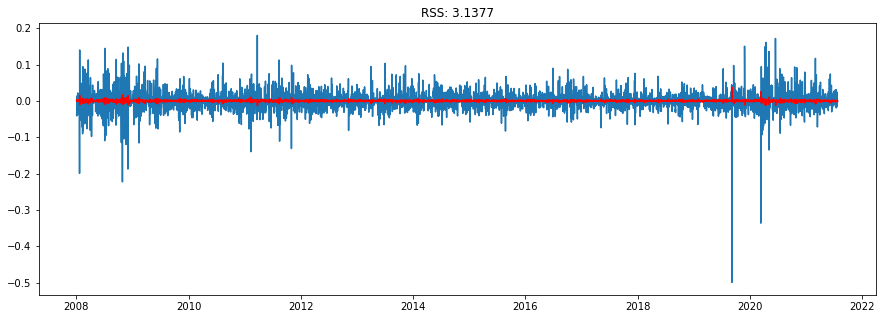

In [474]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(df_log, order= (AR, I, 0))
results_AR = model.fit(disp=-1)
plt.plot(df_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% 
          sum((results_AR.fittedvalues - df_log_diff_shifting["Open"])**2))

print("Plotting AR Model")

Plotting MA Model


C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


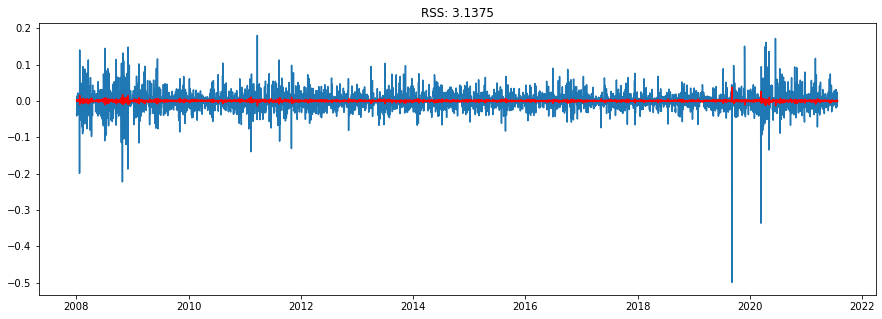

In [475]:

#MA MODEL
model = ARIMA(df_log, order= (0, I, MA))
results_MA = model.fit(disp=-1)
plt.plot(df_log_diff_shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% 
          sum((results_MA.fittedvalues - df_log_diff_shifting["Open"])**2))

print("Plotting MA Model")

C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\udaia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Plotting ARIMA Model


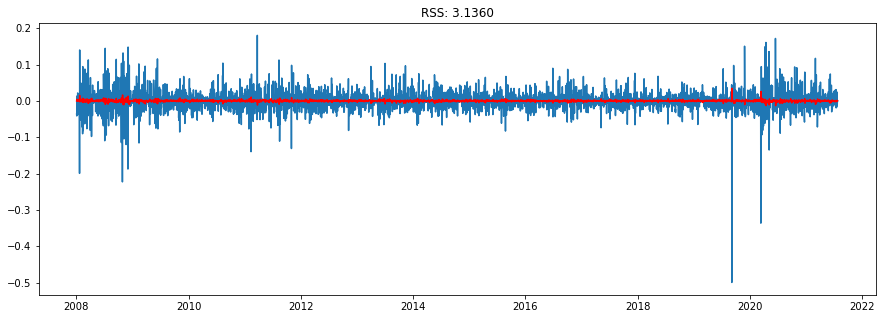

In [476]:

#ARIMA MODEL
model = ARIMA(df_log, order= (AR, I, MA))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% 
          sum((results_ARIMA.fittedvalues - df_log_diff_shifting["Open"])**2))

print("Plotting ARIMA Model")

### Predictions and inverse transformations

In [477]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2008-01-03    0.000119
2008-01-04    0.002637
2008-01-05    0.004271
2008-01-06    0.002113
2008-01-07    0.001082
dtype: float64


In [478]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2008-01-03    0.000119
2008-01-04    0.002756
2008-01-05    0.007027
2008-01-06    0.009140
2008-01-07    0.010222
dtype: float64


In [479]:
predictions_ARIMA_log = pd.Series(df_log["Open"].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
2008-01-02    6.643138
2008-01-03    6.643258
2008-01-04    6.645895
2008-01-05    6.650166
2008-01-06    6.652279
dtype: float64

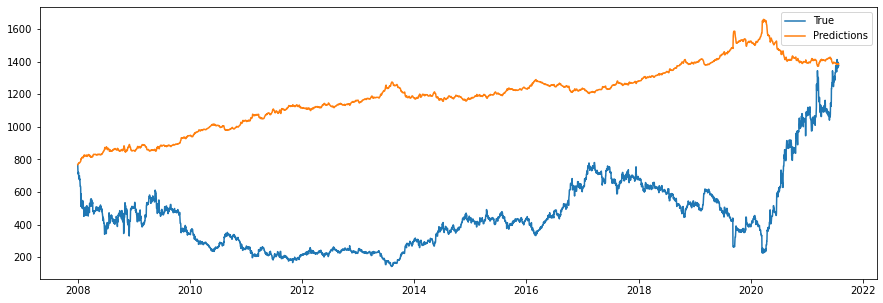

In [480]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df_timeseries, label="True")
plt.plot(predictions_ARIMA, label="Predictions")
plt.legend()

In [481]:
df_log.shape

(4954, 1)

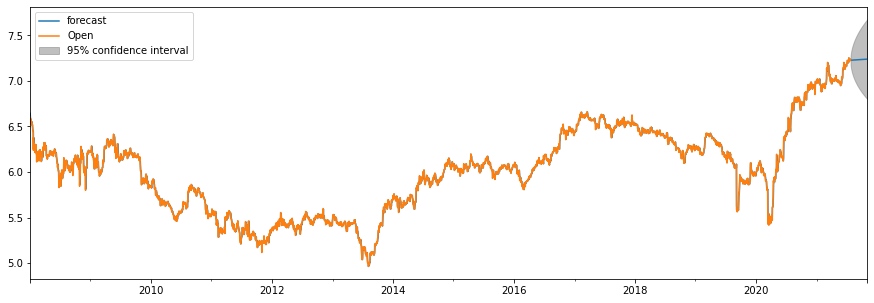

In [482]:
confidence = 95
results_ARIMA.plot_predict(1, df_log.shape[0] + n_predictions, alpha=1.0 - confidence/100)
x = results_ARIMA.forecast(steps=n_predictions, alpha=1.0 - confidence/100)